For this experiment, look at whether gplvm or split-gplvm can recover the embeddings with the simplest simulation, y = f(x), where f is a GP. split-gplvm is made equivalent to gplvm by setting split_space=False and K = 1. There is no split space or mixture here, just normal gplvm. Settings are:
1. Split-GPLVM, optimized w/ scipy
2. Split-GPLVM, optimized w/ natgrad + adam
3. GPLVM optimized w/ scipy

Result
* None of the model recover latent embeddings w/ pleasing visualizations, but seem to be able tell apart different parts of the branching process: node and the 2 branches.
* Scipy for S-GPLVM seem to stuck in local min w/ tiny lengthscales and X, but the visualization still doesn't look too bad

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd

from gpflow.config import default_float
from gpflow import set_trainable

from sklearn.decomposition import PCA

from split_gplvm import SplitGPLVM
from utils import *

In [3]:
# generate high dimensional observation Y ([num_data, dim])
# by mapping X to dim-dimensional space through a GP w/ kernel function
def gen_obs1(X, dim, lengthscales):
    N = X.shape[0]
    k1 = gpflow.kernels.SquaredExponential(lengthscales=lengthscales[0])
    Y = np.random.default_rng().multivariate_normal(np.zeros(N), k1(X), dim).T
    return Y 

In [4]:
np.random.seed(1)

num_data = 200
dim = 5

xmin = 0
xmax = 10
break_pt = 3
k1 = 0.0
k21 = 0.3
k22 = -0.3
c1 = 0
sigma = 0.3
noise = 0
lengthscales = [1]

x = np.linspace(xmin, xmax, int(num_data/2), dtype=default_float())
X = branch_simulation(x, break_pt, k1, k21, k22, c1, sigma)
labels = np.repeat([0, 1], int(num_data)/2)
labels_dummy = pd.get_dummies(labels).values
Y = gen_obs1(X, dim=dim, lengthscales=lengthscales)

Text(0, 0.5, 'observed dimension 2')

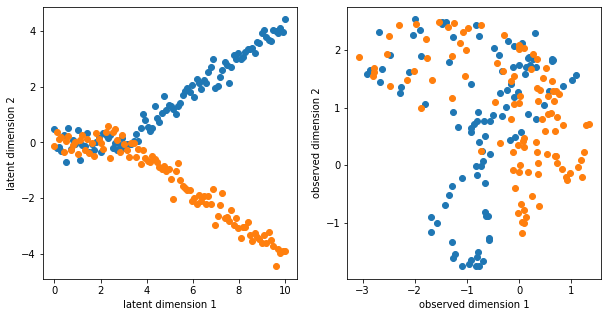

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in np.unique(labels):
    axs[0].scatter(x=X[labels == i, 0], y=X[labels == i, 1])
    axs[1].scatter(x=Y[labels == i, 0], y=Y[labels == i, 1])

axs[0].set_xlabel('latent dimension 1')
axs[0].set_ylabel('latent dimension 2')

axs[1].set_xlabel('observed dimension 1')
axs[1].set_ylabel('observed dimension 2')

In [6]:
np.random.seed(1)

M = 20
X_pca = PCA(n_components=2).fit_transform(Y)
Zp = tf.convert_to_tensor(np.random.permutation(X_pca)[:M], dtype=default_float())
Zs = tf.convert_to_tensor(np.random.permutation(X_pca)[:M], dtype=default_float())

In [7]:
m1 = init_split_gplvm(
    Y=Y,
    split_space=False,
    Qp=2,
    K=1,
    Zp=Zp
)

m2 = init_split_gplvm(
    Y=Y,
    split_space=False,
    Qp=2,
    K=1,
    Zp=Zp
)

m3 = init_gplvm(
    Y,
    latent_dim=2,
    inducing_variable=Zp,
    kernel=gpflow.kernels.SquaredExponential(lengthscales=tf.convert_to_tensor([1.0] * 2, dtype=default_float()))
)

In [9]:
%%time
elbo1 = train_scipy(m1, 3000, step=True)

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
step 0 elbo: -231284.56306336154
step 1 elbo: -2374.47848554424
step 2 elbo: -2098.7533115860874
step 3 elbo: -1724.0426020747198
step 4 elbo: -1455.5327305109197
step 5 elbo: -1453.9149479821476
step 6 elbo: -1452.1534260355445
step 7 elbo: -1452.08988761897
step 8 elbo: -1451.989315964451
step 9 elbo: -1451.9417917594835
step 10 elbo: -1451.9395742311483
step 11 elbo: -1451.9394538596277
step 12 elbo: -1451.9394498609186
step 13 elbo: -1451.939444792696
step 14 elbo: -1451.939444027391
step 15 elbo: -1451.9394433515467
step 16 elbo: -1451.939442113045
step 17 elbo: -1451.9394398393122
step 18 elbo: -1451.939435765412
step 19 elbo: -1451.9394288632934
step 20 elbo: -1451.939418290391
step 21 elbo: -1451.9394034420975
step 22 elbo: -1451.9393815175479
step 23 elbo: -1451.9393433991174
step 24 elbo: -1451.9392786147055
step 25 elbo: -1451.9391801436032
step 26 elbo: -145

In [10]:
%%time
elbo2, pi2 = train_natgrad_adam(m2, 3000, 100)

initial elbo -131313815.7849
iteration 100 elbo -1773.8266, took 0.0295s
iteration 200 elbo -1609.0856, took 0.0422s
iteration 300 elbo -1532.7481, took 0.0270s
iteration 400 elbo -1470.7308, took 0.0312s
iteration 500 elbo -1421.1194, took 0.0263s
iteration 600 elbo -1391.8778, took 0.0243s
iteration 700 elbo -1372.9639, took 0.0249s
iteration 800 elbo -1359.7676, took 0.0289s
iteration 900 elbo -1341.9324, took 0.0266s
iteration 1000 elbo -1333.8297, took 0.0257s
iteration 1100 elbo -1296.4524, took 0.0252s
iteration 1200 elbo -1288.5040, took 0.0267s
iteration 1300 elbo -1286.8273, took 0.0311s
iteration 1400 elbo -1285.9070, took 0.0258s
iteration 1500 elbo -1285.2605, took 0.0320s
iteration 1600 elbo -1284.7592, took 0.0261s
iteration 1700 elbo -1284.3440, took 0.0268s
iteration 1800 elbo -1283.9833, took 0.0252s
iteration 1900 elbo -1283.6587, took 0.0328s
iteration 2000 elbo -1283.3575, took 0.0854s
iteration 2100 elbo -1283.0636, took 0.0265s
iteration 2200 elbo -1282.6938, too

In [11]:
%%time
elbo3 = train_scipy(m3, 3000, step=True)

step 0 elbo: -1523.7892383385836
step 1 elbo: -1457.5138868044705
step 2 elbo: -1386.95326278627
step 3 elbo: -1329.215016751799
step 4 elbo: -1307.9525857628907
step 5 elbo: -1300.2609749952833
step 6 elbo: -1288.6707018123618
step 7 elbo: -1272.358455754863
step 8 elbo: -1260.463168807279
step 9 elbo: -1256.0630075555903
step 10 elbo: -1248.1865624966122
step 11 elbo: -1234.9003006070925
step 12 elbo: -1225.6216582697864
step 13 elbo: -1222.7000845256898
step 14 elbo: -1218.3575971101918
step 15 elbo: -1212.7482901402277
step 16 elbo: -1207.5791309778185
step 17 elbo: -1204.622018768429
step 18 elbo: -1201.8688036223639
step 19 elbo: -1198.9844964361296
step 20 elbo: -1196.088740987845
step 21 elbo: -1192.5566131216647
step 22 elbo: -1188.0066081143586
step 23 elbo: -1185.0009689460371
step 24 elbo: -1183.6166360825684
step 25 elbo: -1181.3763874867375
step 26 elbo: -1177.3949736246448
step 27 elbo: -1170.8265597981417
step 28 elbo: -1164.6129044818613
step 29 elbo: -1163.66118676107

step 239 elbo: -1018.6437055674439
step 240 elbo: -1018.5582110124758
step 241 elbo: -1018.5206966390936
step 242 elbo: -1018.4652861663541
step 243 elbo: -1018.3995517956024
step 244 elbo: -1018.3791329988144
step 245 elbo: -1018.3439986371643
step 246 elbo: -1018.2880289937373
step 247 elbo: -1018.2554592026186
step 248 elbo: -1018.2010036342424
step 249 elbo: -1018.1362377110372
step 250 elbo: -1018.0901351404098
step 251 elbo: -1018.0168878910906
step 252 elbo: -1017.9506562715396
step 253 elbo: -1017.8741367058642
step 254 elbo: -1017.772915837957
step 255 elbo: -1017.7247810389612
step 256 elbo: -1017.6569150212154
step 257 elbo: -1017.6220486157146
step 258 elbo: -1017.5931926712476
step 259 elbo: -1017.54898058194
step 260 elbo: -1017.5189502802768
step 261 elbo: -1017.475275772829
step 262 elbo: -1017.4190127609645
step 263 elbo: -1017.3892126289471
step 264 elbo: -1017.3436934356295
step 265 elbo: -1017.30581958928
step 266 elbo: -1017.2835300953086
step 267 elbo: -1017.24913

step 474 elbo: -1014.2805567870072
step 475 elbo: -1014.2804659237156
step 476 elbo: -1014.2803247121813
step 477 elbo: -1014.2800793675904
step 478 elbo: -1014.2799449425174
step 479 elbo: -1014.2797230138672
step 480 elbo: -1014.2794045096377
step 481 elbo: -1014.2792969704908
step 482 elbo: -1014.2791196310072
step 483 elbo: -1014.2789413035487
step 484 elbo: -1014.2789090476659
step 485 elbo: -1014.278847628996
step 486 elbo: -1014.278761478195
step 487 elbo: -1014.278617423503
step 488 elbo: -1014.2784298525426
step 489 elbo: -1014.2783812874663
step 490 elbo: -1014.2782985770507
step 491 elbo: -1014.2782251407993
step 492 elbo: -1014.2782099366534
step 493 elbo: -1014.2781809839266
step 494 elbo: -1014.2781420465857
step 495 elbo: -1014.2780815412011
step 496 elbo: -1014.2779979893255
step 497 elbo: -1014.2779846936387
step 498 elbo: -1014.2779632220402
step 499 elbo: -1014.2779338381212
step 500 elbo: -1014.2779269672882
step 501 elbo: -1014.2779155450723
step 502 elbo: -1014.27

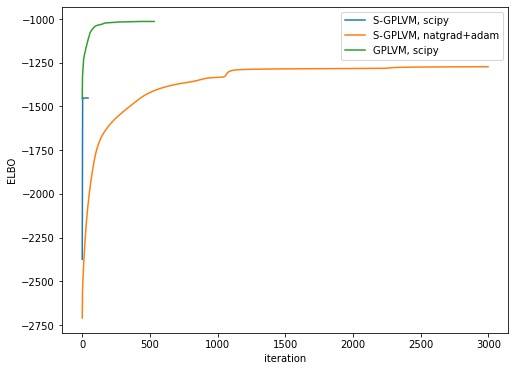

In [18]:
plt.figure(figsize=(8, 6))
names = [
    'S-GPLVM, scipy',
    'S-GPLVM, natgrad+adam',
    'GPLVM, scipy'
]
elbos = [elbo1, elbo2, elbo3]
for i, elbo in enumerate(elbos):
    plt.plot(elbo[1:], label=names[i])
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.legend()

<AxesSubplot:>

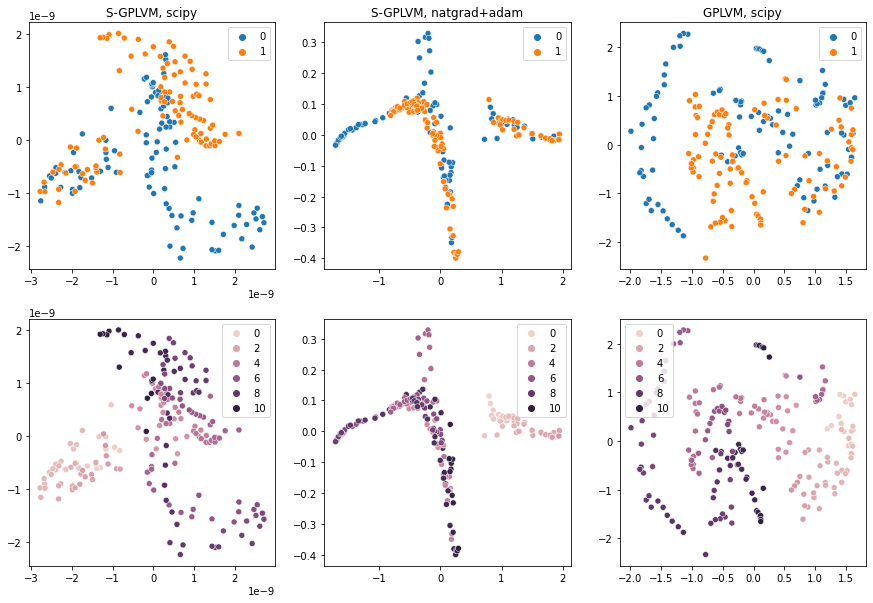

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

sns.scatterplot(x=m1.Xp_mean[:, 0], y=m1.Xp_mean[:, 1], hue=labels, ax=axs[0, 0])
axs[0, 0].set_title(names[0])
sns.scatterplot(x=m2.Xp_mean[:, 0], y=m2.Xp_mean[:, 1], hue=labels, ax=axs[0, 1])
axs[0, 1].set_title(names[1])
sns.scatterplot(x=m3.X_data_mean[:, 0], y=m3.X_data_mean[:, 1], hue=labels, ax=axs[0, 2])
axs[0, 2].set_title(names[2])

sns.scatterplot(x=m1.Xp_mean[:, 0], y=m1.Xp_mean[:, 1], hue=X[:, 0], ax=axs[1, 0])
sns.scatterplot(x=m2.Xp_mean[:, 0], y=m2.Xp_mean[:, 1], hue=X[:, 0], ax=axs[1, 1])
sns.scatterplot(x=m3.X_data_mean[:, 0], y=m3.X_data_mean[:, 1], hue=X[:, 0], ax=axs[1, 2])

In [13]:
m1

name,class,transform,prior,trainable,shape,dtype,value
SplitGPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0668585961763672
SplitGPLVM.kernel_K[0].variance,Parameter,Softplus,,True,(),float64,0.03237316846914555
SplitGPLVM.kernel_K[0].lengthscales,Parameter,Softplus,,True,"(2,)",float64,[6.95639351e-07 9.29535702e-06]
SplitGPLVM.Xp_mean,Parameter,,,True,"(200, 2)",float64,"[[-1.30174565e-09, -5.92313318e-10..."
SplitGPLVM.Xp_var,Parameter,Softplus,,True,"(200, 2)",float64,"[[1.00000002, 0.99999954..."
SplitGPLVM.pi,Parameter,SoftmaxCentered,,True,"(200, 1)",float64,[[1....
SplitGPLVM.Zp.Z,Parameter,,,True,"(20, 2)",float64,"[[-1.40435240e+00, 2.13114191e+00..."
SplitGPLVM.q_mu,Parameter,,,True,"(20, 5)",float64,"[[9.28778550e-11, -1.56246794e-10, 1.97494457e-11..."
SplitGPLVM.q_sqrt,Parameter,FillTriangular,,True,"(5, 20, 20)",float64,"[[[9.21017809e-01, 0.00000000e+00, 0.00000000e+00..."


In [14]:
m2

name,class,transform,prior,trainable,shape,dtype,value
SplitGPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.41008464960065305
SplitGPLVM.kernel_K[0].variance,Parameter,Softplus,,True,(),float64,0.026953533330301285
SplitGPLVM.kernel_K[0].lengthscales,Parameter,Softplus,,True,"(2,)",float64,[0.43731173 3.87190493]
SplitGPLVM.Xp_mean,Parameter,,,True,"(200, 2)",float64,"[[9.57730958e-01, 3.62606629e-02..."
SplitGPLVM.Xp_var,Parameter,Softplus,,True,"(200, 2)",float64,"[[0.06877629, 1.08697181..."
SplitGPLVM.pi,Parameter,SoftmaxCentered,,True,"(200, 1)",float64,[[1....
SplitGPLVM.Zp.Z,Parameter,,,True,"(20, 2)",float64,"[[-1.81249152, -0.21549439..."
SplitGPLVM.q_mu,Parameter,,,False,"(20, 5)",float64,"[[-1.06779526e+00, -1.25974367e+00, 1.27862962e+00..."
SplitGPLVM.q_sqrt,Parameter,FillTriangular,,False,"(5, 20, 20)",float64,"[[[1.59203156e-01, 0.00000000e+00, 0.00000000e+00..."


In [15]:
m3

name,class,transform,prior,trainable,shape,dtype,value
BayesianGPLVM.kernel.variance,Parameter,Softplus,,True,(),float64,1.011115558219932
BayesianGPLVM.kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[0.67015085 2.14739656]
BayesianGPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.055063375440659916
BayesianGPLVM.X_data_mean,Parameter,,,True,"(200, 2)",float64,"[[1.19363863, 0.24820571..."
BayesianGPLVM.X_data_var,Parameter,Softplus,,True,"(200, 2)",float64,"[[0.00324291, 0.02271871..."
BayesianGPLVM.inducing_variable.Z,Parameter,,,True,"(20, 2)",float64,"[[-0.97153598, -0.55078728..."
